Data from https://www.ncei.noaa.gov/products/optimum-interpolation-sst

The anomaly data has the shape (1, 1, 720, 1440). We can just keep the last two indeces!

In [1]:
# Math libraries
import numpy as np
import pandas as pd
import scipy.linalg as li
# Used for average pooling to downsample data
import skimage.measure as skm

# Reading netcdf4 files
from netCDF4 import Dataset
import xarray as xr
# For regridding data
import xesmf as xe

# For multiprocessing
from multiprocess import Pool
import dask
# To find files
import os

# Functools partial for preprocess step of unpacking data
from functools import partial

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.basemap import Basemap

In [2]:
# SST data file paths
files = filter(lambda file : file[-2:] == 'nc', os.listdir('./data'))
# Adding ./data to path name
files = np.array(list(map(lambda f: './data/' + f, files)))
# Sorting paths
files.sort()
print(files)

['./data/oisst-avhrr-v02r01.19820101.nc'
 './data/oisst-avhrr-v02r01.19820102.nc'
 './data/oisst-avhrr-v02r01.19820103.nc' ...
 './data/oisst-avhrr-v02r01.20231229.nc'
 './data/oisst-avhrr-v02r01.20231230.nc'
 './data/oisst-avhrr-v02r01.20231231.nc']


We want to calculate the covariance matrix at lag $\tau_0$ and with no lag, $C_{\tau_0}$ and $C_0$ respectively. We can calculate them as:

$$
C_{\tau_0} = \left< \textbf{x}(t + \tau_0) \textbf{x}^T(t) \right>
$$

$$
C_0 = \left< \textbf{x}(t) \textbf{x}^T(t) \right>
$$

We need to reduce the size of the state space. First, we can change our grid to be 2.5 degrees wide, instead of 1/4. We also will focus our efforts on the central pacific basin.

In [5]:
# Preprocess step for unpacking data
# x is an xarray object with a time, lat, and lon field
# lon_bnds is a tuple of the longitude bounds of data to keep
# lat_nds is a tuple of the latitude bounds of data to keep
# Regridder is an xesmf regridder object, used to regrid data. This is precomputed outside so we can parralelize later
def _preprocess(x, lon_bnds, lat_bnds, regridder):
    # Only keeping data within bounds
    new_x = x.sel(lon=slice(*lon_bnds), lat=slice(*lat_bnds))
    # Regridding and returning result
    return regridder(new_x['anom'], keep_attrs=True)

##------------------------- Grid boundaries and dataset -------------------------##
# Lat lon bounds
lon_bnds = (30, 290)
lat_bnds = (-30, 30)
# New coords to regrid to
new_grid = xr.Dataset(
    {
        "lat": (["lat"], np.arange(lat_bnds[0], lat_bnds[1], 4), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(lon_bnds[0], lon_bnds[1], 10), {"units": "degrees_east"}),
    })

##-------------------------- Creating regridder to use --------------------------##
# Opening first file in data
regrid_x = xr.open_dataset(files[0], drop_variables=['zlev'])
# Keeping data in lat lon bounds
regrid_x = regrid_x.sel(lon=slice(*lon_bnds), lat=slice(*lat_bnds))
# Generating regridder
regridder = xe.Regridder(regrid_x, new_grid, "bilinear")

# Using functools process to give to xarray
partial_preprocess = partial(_preprocess, lon_bnds=lon_bnds, lat_bnds=lat_bnds, regridder=regridder)

In [6]:
# Only run once
try:
    if DATASET_LOADED:
        print("Dataset loaded!")
except:
    # Opening all data in data folder and applying preprocess step
    dataset = xr.open_mfdataset("./data/*.nc", drop_variables=['zlev'], preprocess=partial_preprocess, parallel=True)
DATASET_LOADED = True;

In [7]:
dataset

<xarray.Dataset> Size: 24MB
Dimensions:  (time: 15340, zlev: 1, lat: 15, lon: 26)
Coordinates:
  * time     (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-31T1...
  * lat      (lat) int64 120B -30 -26 -22 -18 -14 -10 -6 -2 2 6 10 14 18 22 26
  * lon      (lon) int64 208B 30 40 50 60 70 80 90 ... 230 240 250 260 270 280
Dimensions without coordinates: zlev
Data variables:
    anom     (time, zlev, lat, lon) float32 24MB dask.array<chunksize=(1, 1, 15, 26), meta=np.ndarray>

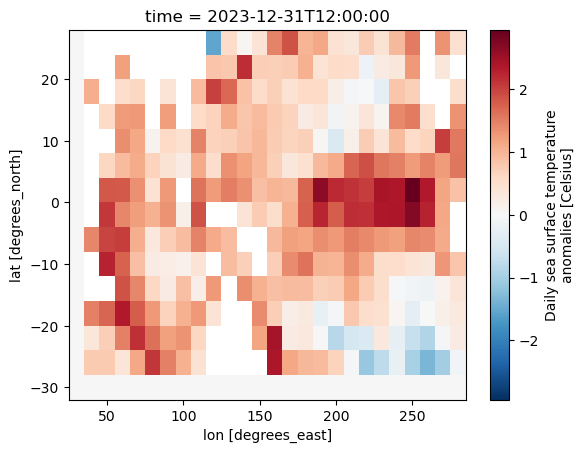

In [8]:
dataset['anom'].isel(time=-1).isel(zlev=0).plot()

In [3]:
# Reducing dataset to central pacific basin
# lat_range is a tuple (low, high)
# lon_range is a tuple (low, high)
def truncate_region(anom, lats, lons, lat_range, lon_range):
    # Masks for regions
    lat_mask = (lats > lat_range[0]) * (lats < lat_range[1])
    lon_mask = (lons > lon_range[0]) * (lons < lon_range[1])
    res = anom[lat_mask]
    res = res.transpose()[lon_mask]
    return res.transpose().data

In [4]:
# Making unpacking anomalies into a function so we can use multiprocessing
def unpack_anom(file, lats, lons, block_size, lat_range, lon_range):
    # Opening file
    with Dataset(file, 'r') as rootgrp:
        # Getting data
        full_anom = rootgrp['anom'][0][0]
        # Truncating anoms to a specified region
        trunc_anoms = truncate_region(full_anom, lats, lons, lat_range, lon_range)
        # Downsampling
        avg_anoms = skm.block_reduce(trunc_anoms, (5, 5), np.average)
    # Return result    
    return avg_anoms

In [5]:
# Getting latitude and longitudes from first file
with Dataset(files[0], 'r') as rootgrp:
    lats = np.array(rootgrp['lat'])
    lons = np.array(rootgrp['lon'])

# Latitude and longitude range
lat_range = (-15, 15)
lon_range = (165, 265)
# Averaging block size
block_size = 5
# Size of each individual anomaly set after process
# CHANGE THIS IF YOU CHANGE PARAMETERS
anoms_shape = (24, 16)
# Allocating memory for anomalies
anoms = np.zeros((len(files), *anoms_shape))
# Averaging latitudes
lat_mask = (lats > lat_range[0]) * (lats < lat_range[1])
avg_lats = skm.block_reduce(lats[lat_mask], 5, np.average)
# Averaging longitudes
lon_mask = (lons > lon_range[0]) * (lons < lon_range[1])
avg_lons = skm.block_reduce(lons[lon_mask], 5, np.average)

In [6]:
# Doing multiprocessing
with Pool(15) as p:
    full_anoms = np.array(p.map(lambda f: unpack_anom(f, lats, lons, block_size, lat_range, lon_range), files))

In [7]:
# To further reduce the amount of data we have, we can do a 5 day running mean
# Number of arrays to split up anoms into
N = len(full_anoms)/5
# Splitting anoms
print(f'Before 5 day running mean shape: {full_anoms.shape}')
anoms = np.array(np.split(full_anoms, N))
# Averaging over 5 days
anoms = np.average(anoms, axis=1)
print(f'After 5 day running mean shape: {anoms.shape}')

Before 5 day running mean shape: (15340, 24, 80)
After 5 day running mean shape: (3068, 24, 80)


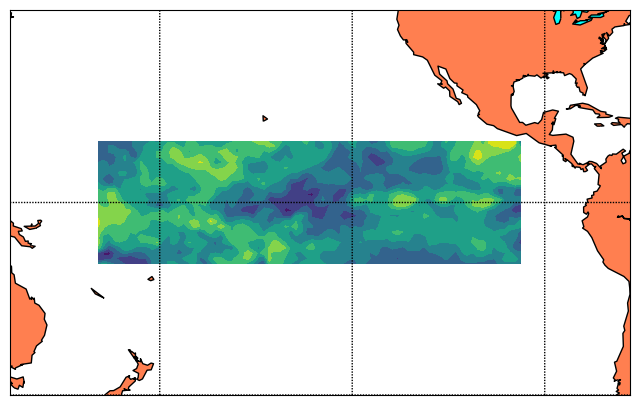

In [14]:
# Plotting an SST
# Index of SST to plot
index = 10
# Center of map
# Map corners
mlats = (-45, 45)
mlons = (145, 290)
lat0 = np.average(mlats)
lon0 = np.average(mlons)

# Setting figure size
plt.figure(figsize=(10, 5))
# Current figure
fig = plt.gcf()

# Basemap
m = Basemap(llcrnrlon=mlons[0], llcrnrlat=mlats[0], urcrnrlon=mlons[1], urcrnrlat=mlats[1], 
            projection='cyl', lat_0=lat0, lon_0=lon0)

# Drawing land
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')

# Drawing parallels and meridians
m.drawparallels(np.arange(-90, 91, 45))
m.drawmeridians(np.arange(0, 361, 45))

# Making lats and lons into grid for plotting
X, Y = np.meshgrid(avg_lons, avg_lats)

# Plotting contours
m.contourf(X, Y, anoms[index], latlon=True)

plt.show()

In [40]:
# Getting maximum and minimum anomalies for plotting
max_anomaly = np.max(anoms)
min_anomaly = np.min(anoms)
print(f"Maximum anomaly: {max_anomaly}\nMinimum Anomaly: {min_anomaly}")

Maximum anomaly: 6.057999610900879
Minimum Anomaly: -7.589200019836426


In [107]:
%matplotlib notebook

# Animating SSTs
# Map corners
mlats = (-45, 45)
mlons = (145, 290)
lat0 = np.average(mlats)
lon0 = np.average(mlons)

# Setting figure size
plt.figure(figsize=(10, 5))
# Current figure
fig = plt.gcf()

# Basemap
m = Basemap(llcrnrlon=mlons[0], llcrnrlat=mlats[0], urcrnrlon=mlons[1], urcrnrlat=mlats[1], 
            projection='cyl', lat_0=lat0, lon_0=lon0)

# Drawing land
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')

# Drawing parallels and meridians
m.drawparallels(np.arange(-90, 91, 45))
m.drawmeridians(np.arange(0, 361, 45))

# Color values
cvals = np.linspace(min_anomaly, max_anomaly, 15)
# Plotting contours
cont = m.contourf(X, Y, anoms[0], cvals, latlon=True)

# Making lats and lons into grid for plotting
X, Y = np.meshgrid(avg_lons, avg_lats)

# Animation function
def update(frame):
    global cont
    z = anoms[frame]
    for c in cont.collections:
        c.remove() # Removing contour artists to improve preformance
    cont = m.contourf(X, Y, z, cvals, latlon=True)
    return cont

anim = animation.FuncAnimation(fig=fig, func=update, frames=30, interval=30)
plt.show()

<IPython.core.display.Javascript object>

/Users/prem/opt/miniconda3/envs/sst-lim/lib/python3.12/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [82]:
# A method to calculate the covariance matrix of a given state vector
def covariance(anom):
    # Reshaping anomalies matrix to be a vector
    n, m = anom.shape
    x = anom.reshape(n*m)
    # Calculating covariance
    return np.outer(x, x)

In [83]:
weights = np.sqrt(np.cos(np.radians(avg_lats)))
weighted_anoms = np.zeros(anoms[0].shape)

for i, w in enumerate(weights):
    weighted_anoms[i] = weights[i]*anoms[0][i]

In [84]:
avg_lats

array([-14.375, -13.125, -11.875, -10.625,  -9.375,  -8.125,  -6.875,
        -5.625,  -4.375,  -3.125,  -1.875,  -0.625,   0.625,   1.875,
         3.125,   4.375,   5.625,   6.875,   8.125,   9.375,  10.625,
        11.875,  13.125,  14.375], dtype=float32)

In [85]:
weights

array([0.98422134, 0.98685205, 0.9892416 , 0.9913904 , 0.9932992 ,
       0.9949684 , 0.9963983 , 0.99758947, 0.998542  , 0.9992562 ,
       0.99973226, 0.99997026, 0.99997026, 0.99973226, 0.9992562 ,
       0.998542  , 0.99758947, 0.9963983 , 0.9949684 , 0.9932992 ,
       0.9913904 , 0.9892416 , 0.98685205, 0.98422134], dtype=float32)

In [88]:
# A method to cosine weight ssts
def cosine_weight(anom, lats):
    # Cosine weights
    rad_lats = np.radians(lats)
    weights = np.sqrt(np.cos(rad_lats))
    # Return array
    res = np.zeros((anom.shape))
    # Weighting
    for i, w in enumerate(weights):
        res[i] = w * anom[i]
    return res

In [89]:
# Allocating memory for covariance matrix
n, m = anoms[0].shape
cov = np.zeros((n*m, n*m))
# Calculating covariance matrix
for anomaly in anoms:
    cov += covariance(cosine_weight(anomaly, avg_lats))

# Averaging step
cov = cov / len(anoms)

In [90]:
# Getting eigenvectors of covariance matrix
evals, evecs = li.eig(cov)
# Real if close
evecs = np.real_if_close(evecs, tol=1)
evals = np.real_if_close(evals, tol=1)

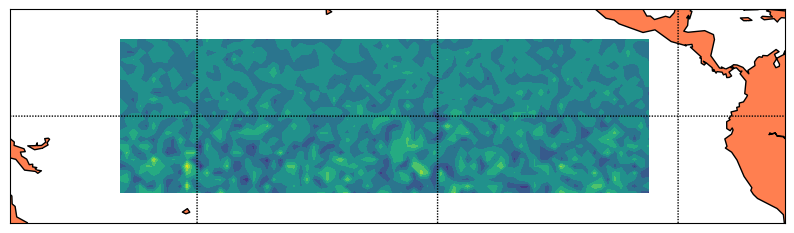

In [103]:
# Plotting an EOF
# Center of map
# Map corners
mlats = (-20, 20)
mlons = (145, 290)
lat0 = np.average(mlats)
lon0 = np.average(mlons)

# Setting figure size
plt.figure(figsize=(10, 5))

# Basemap
m = Basemap(llcrnrlon=mlons[0], llcrnrlat=mlats[0], urcrnrlon=mlons[1], urcrnrlat=mlats[1], 
            projection='cyl', lat_0=lat0, lon_0=lon0)

# Drawing land
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')

# Drawing parallels and meridians
m.drawparallels(np.arange(-90, 91, 45))
m.drawmeridians(np.arange(0, 361, 45))

# Making lats and lons into grid for plotting
X, Y = np.meshgrid(avg_lons, avg_lats)

# Index of EOF to plot
index = 0

# Plotting contours
m.contourf(X, Y, evecs[index].reshape(anoms[0].shape), latlon=True)

plt.show()

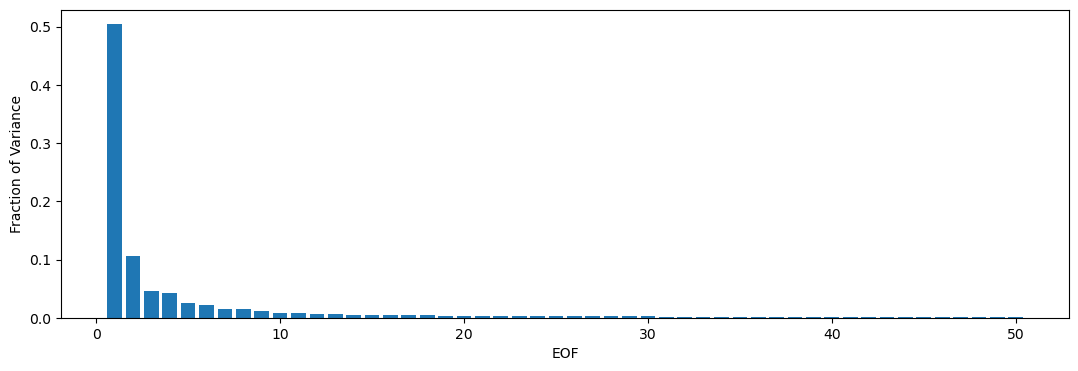

In [96]:
#### Plotting variance percentage of each EOF
# Calculating variance
variance = evals / np.sum(evals)
# Number of evals to plot
stop = 50
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(13, 4))
# Bar chart! Yay!
ax.bar(np.arange(1, len(evals[:stop]) + 1), variance[:stop])

ax.set_xlabel("EOF")
ax.set_ylabel("Fraction of Variance")

plt.show()

In [97]:
# Calculating total variance of first several EOFs
num_to_keep = 10
print(f"For {num_to_keep} EOFs, the variance we keep is {round(np.sum(evals[:num_to_keep])/np.sum(evals)*100, 2)}% of the total") 

For 10 EOFs, the variance we keep is 79.45% of the total


In [98]:
# Creating projection matrix
proj = evecs[:num_to_keep]
# Projecting anoms into EOF space
proj_anoms = np.zeros((len(anoms), num_to_keep))
for i, anomaly in enumerate(anoms):
    proj_anoms[i] = proj @ cosine_weight(anomaly, avg_lats).flatten()

In [99]:
# Calculating covariance matrix
eof_cov = np.zeros((num_to_keep, num_to_keep))
for e in proj_anoms:
    eof_cov += np.outer(e, e)
eof_cov = eof_cov / len(proj_anoms)

# Calculating lagged covariance matrix
# Lag in indices
n = 1
proj_lag_cov = np.zeros((num_to_keep, num_to_keep))
for lagged, current in zip(proj_anoms[n:], proj_anoms[:-n]):
    proj_lag_cov += np.outer(lagged, current)
proj_lag_cov = proj_lag_cov / len(proj_anoms)

In [100]:
# Calculating L
L = 1/(n * 5) * li.logm(proj_lag_cov @ li.inv(eof_cov))

In [101]:
Lvals, Lvecs = li.eig(L)

In [102]:
Lvals

array([-0.11143156+0.00430938j, -0.11143156-0.00430938j,
       -0.094381  +0.j        , -0.08498659+0.j        ,
       -0.00804945+0.j        , -0.0590763 +0.00902193j,
       -0.0590763 -0.00902193j, -0.05059441+0.j        ,
       -0.0194185 +0.j        , -0.02793584+0.j        ])